# Artificial Neural Networks and Deep Learning

---

## Homework 2: Mkinimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("/content/drive/My Drive/cleaned_mars_dataset_with_no_ufo.npz")

# training_set = data["training_set"]
X_train = data["X_train"]
y_train =  data["y_train"]

# X_test = data["test_set"]

#X_train = X_train.astype(np.int32)

# print(f"Training X shape: {X_train.shape}")
# print(f"Training y shape: {y_train.shape}")
# print(f"Test X shape: {X_test.shape}")

# #cast labels to int32
# y_train = y_train.astype(np.int32)

# print(f"Type of pixel in X_train: {type(X_train[0][0][0])} (={X_train[0][0][0]})")
# print(f"Type of pixel in y_train: {type(y_train[0][0][0])} (={y_train[0][0][0]})")

# #X_train = X_train / 255
# #y_train = y_train / 255

In [ ]:
# Set batch size for training
batch_size = 64

# Set learning rate for the optimiser
learning_rate = 1e-3

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 1000

# Set data split size for training and validation
splits_size = int(0.1 * len(X_train))

seed = 42

## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
# X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Split the data (not the paths!!!) into training, validation, and test sets
print("Splitting data...")
# train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#     X_train, y_train, test_size=splits_size#, random_state=seed
# )
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=splits_size#, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
# print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 24755
Validation: 2750


In [ ]:
# Define the category mapping
category_map = {
      0: 0, #Background
      1: 1, #Soil
      2: 2, #Bedrock
      3: 3, #Sand
      4: 4, #Big Rock
  }

# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [ ]:
def flip_horizontal(image):
    return tf.reverse(image, axis=[1])  # Reverse along the width axis (axis 1)


def make_dataset(image_paths, label_paths, batch_size, shuffle=False, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    #if augment:
      #pass
      #duplicate each image and flip one of the duplicates
      #dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices([(x, y), (flip_horizontal(x), y)]))

    """dataset = dataset.map(
        lambda x, y: layers.random_flip(x, y, seed=seed),
        num_parallel_calls=tf.data.AUTOTUNE
    )"""

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """


    """# Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label"""
    #image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [ ]:
def apply_category_mapping(label):
    """    Apply category mapping to labels.

    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
# Create the datasets
print("Creating datasets...")


train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=batch_size,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
print(train_dataset.take(1))
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!
<_TakeDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 64, 128), dtype=tf.int32, name=None))>

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


##Custom loss function to ignore 0 class

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()  # Use tf.keras.utils instead of tfk.saving
def loss_0_ignored(y_true, y_pred):
    indices_to_keep = tf.not_equal(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, indices_to_keep)
    y_pred_masked = tf.boolean_mask(y_pred, indices_to_keep)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  # Use tf.keras.losses
    return loss_fn(y_true_masked, y_pred_masked)

##Our model

In [ ]:
#This is UNet with Dice Loss Function



#with dice loss
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    num_classes = tf.shape(y_pred)[-1]
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true_one_hot + y_pred, axis=[1, 2])

    dice = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - tf.reduce_mean(dice, axis=0)

    return dice_loss

# U-Net Model
def build_unet(input_shape=(64, 128, 1), num_classes=5):
    initial = 4
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(initial, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(initial, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(initial * 2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(initial * 2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(initial * 4, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(initial * 4, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b1 = layers.Conv2D(initial * 8, (3, 3), activation='relu', padding='same')(p3)
    b1 = layers.Conv2D(initial * 8, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b1)
    u1 = layers.concatenate([u1, c3])
    c4 = layers.Conv2D(initial * 4, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(initial * 4, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(initial * 2, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(initial * 2, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.concatenate([u3, c1])
    c6 = layers.Conv2D(initial, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(initial, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c6)

    model = models.Model(inputs, outputs)
    # Change the metric to use sparse categorical accuracy
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=dice_loss,
        metrics=["accuracy", tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)] # Set sparse_y_true=True for non-one-hot labels
    )
    return model

# Build the model
model = build_unet(input_shape=(64, 128, 1), num_classes=5)

# Print summary
model.summary()

# Train the model

history = model.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Save the model
model.save(f"unet_dice_model.keras")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 4)     │             40 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 4)     │            148 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 4)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 8)      │            296 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 8)      │            584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 8)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 16)     │          1,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 32, 16)     │          2,320 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 16, 16)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 16, 32)      │          4,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 16, 32)      │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 32, 32)     │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 32, 48)     │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 32, 16)     │          6,928 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 32, 16)     │          2,320 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 64, 16)     │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 30,621 (119.61 KB)

 Trainable params: 30,621 (119.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.3486 - loss: 0.8805 - mean_io_u: 0.0401 - val_accuracy: 0.3635 - val_loss: 0.8482 - val_mean_io_u: 0.0921
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3859 - loss: 0.8333 - mean_io_u: 0.1254 - val_accuracy: 0.4532 - val_loss: 0.8105 - val_mean_io_u: 0.1799
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4664 - loss: 0.8058 - mean_io_u: 0.1874 - val_accuracy: 0.4880 - val_loss: 0.7937 - val_mean_io_u: 0.2245
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4938 - loss: 0.7938 - mean_io_u: 0.2076 - val_accuracy: 0.4848 - val_loss: 0.7918 - val_mean_io_u: 0.2425
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5096 - loss: 0.7861 - mean_io_u: 0.2237 - val_accuracy: 0.5195 - val_loss: 0.7806 - val_mean_io_u: 0.2389
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5293 - loss: 0.7774 - mean_io_u: 0.2367 - val_accuracy: 0.5284 

In [ ]:
#We used SegNet here
import tensorflow as tf
from tensorflow.keras import layers, models

def build_segnet(input_shape=(64, 128, 1), num_classes=5):
    """
    Builds a SegNet model for semantic segmentation.
    Args:
        input_shape (tuple): Shape of the input image (H, W, C).
        num_classes (int): Number of output classes (including background).

    Returns:
        model (tf.keras.Model): Compiled SegNet model.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    p5 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(c5)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p5)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)

    u2 = layers.UpSampling2D((2, 2))(d1)
    d2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u2)
    d2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)

    u3 = layers.UpSampling2D((2, 2))(d2)
    d3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    d3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d3)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)

    u4 = layers.UpSampling2D((2, 2))(d3)
    d4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)

    u5 = layers.UpSampling2D((2, 2))(d4)
    d5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d5)

    model = models.Model(inputs, outputs)

    # Compile the model
    mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=loss_0_ignored, metrics=[mean_iou])

    # model.compile(
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    #     loss='sparse_categorical_crossentropy',
    #     metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=num_classes)]
    # )

    return model

# Build the SegNet model
model = build_segnet(input_shape=(64, 128, 1), num_classes=5)

# Print model summary
model.summary()

# Train the SegNet model
history = model.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Save the trained model
model.save("segnet_model.keras")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 128, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 128, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 16, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 16, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 16, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 16, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 4, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 4, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 4, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,426,309 (112.25 MB)

 Trainable params: 29,426,309 (112.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 231s 486ms/step - loss: 1.3003 - mean_io_u: 0.0938 - val_loss: 1.2137 - val_mean_io_u: 0.0825
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 121s 313ms/step - loss: 1.2123 - mean_io_u: 0.0954 - val_loss: 1.2117 - val_mean_io_u: 0.0838
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 140s 307ms/step - loss: 1.2107 - mean_io_u: 0.0965 - val_loss: 1.2106 - val_mean_io_u: 0.0984
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 144s 312ms/step - loss: 1.2100 - mean_io_u: 0.0932 - val_loss: 1.2168 - val_mean_io_u: 0.0760
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 142s 311ms/step - loss: 1.2102 - mean_io_u: 0.0970 - val_loss: 1.2101 - val_mean_io_u: 0.1247
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 142s 311ms/step - loss: 1.2100 - mean_io_u: 0.0935 - val_loss: 1.2099 - val_mean_io_u: 0.1209
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 140s 307ms/step - loss: 1.2094 - mean_io_u: 0.0874 - val_loss: 1.2097 - val_mean_io_u: 0.1117
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 118s 306ms/step - loss

## Display predictions

Visualizing examples from the test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


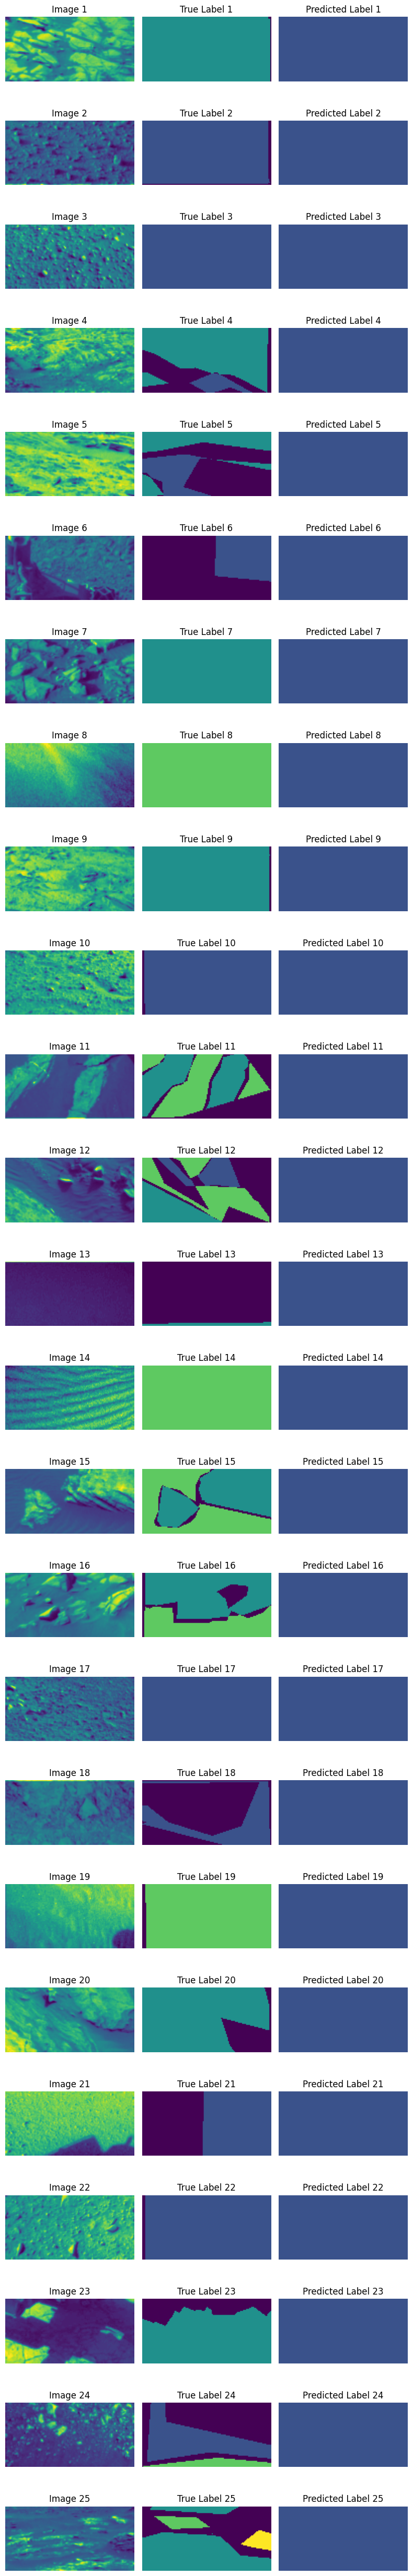

In [ ]:
def plot_sample_batch(dataset, num_samples=25):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(8, 2*num_samples))
    #plt.figure()
    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 3, j*3 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 3, j*3 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'True Label {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 3, j*3 + 3)
            #image_extra_axis = np.expand_dims(images[j], axis=2)
            image_extra_axis = images[j][None,...]
            #print(f"image_extra_axis = {image_extra_axis}")
            #print(f"images[{j}] = {images[j]}")
            prediction = model.predict(image_extra_axis) #adding an extra axis to make sure shape is correct
            prediction = np.argmax(prediction, axis=-1)

            colored_label = apply_colormap(prediction, colormap)
            plt.imshow(colored_label)
            plt.title(f'Predicted Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the test set:")
plot_sample_batch(test_dataset,25)

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241211_203538.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241211_203538.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>